<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/0905_chap4_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.1 선형 회귀

선형 모델: 입력 특성의 가중치 합과 편향(절편) 상수를 더해 예측 생성

회귀의 가장 일반적 성능 지표:  RMSE, MSE
> 해당 지표를 최소화하는, 비용 함수를 최소화하는 모델 파라미터 vector theta를 찾아야 함

# 4.1.1 정규방정식

비용 함수를 최소화하는 vector theta를 찾기 위한 해석적 방법, 즉 바로 결과를 얻을 수 있는 수학 공식 -> 정규방정식(normal equation)

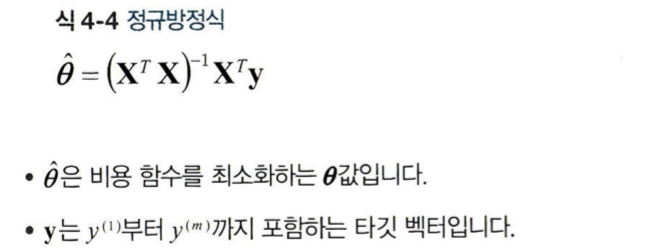

In [1]:
import numpy as np

X = 2 * np.random.rand(100,1) # Uniform(0,1)에서 난수 생성
y = 4 + 3 * X + np.random.randn(100,1) # ND(0,1)에서 난수 생성

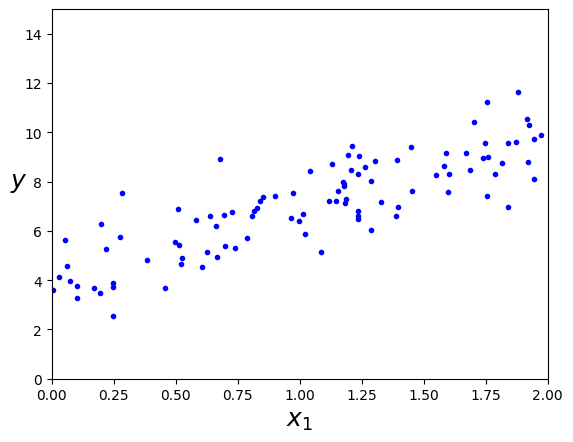

In [4]:
import matplotlib.pyplot as plt

plt.plot(X,y,'b.')
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0,2,0,15])
plt.show()

In [6]:
X_b = np.c_[np.ones((100, 1)), X] # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.04109299],
       [2.91405433]])

잡음 때문에 원래 함수의 파라미터(theta0 = 4, theta1 = 3)와 약간의 오차 발생

In [7]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # 모든 샘플에 x0 = 1 을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.04109299],
       [9.86920166]])

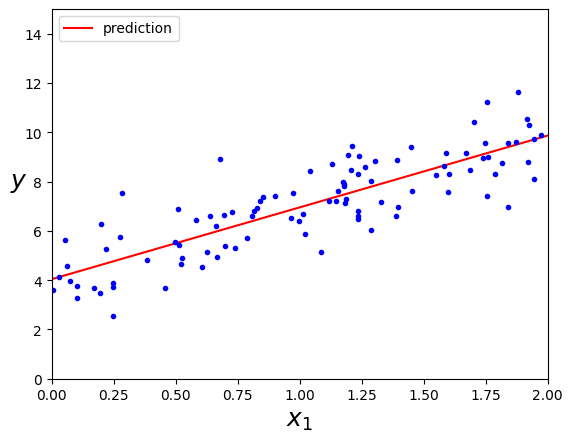

In [14]:
plt.plot(X_new, y_predict, "r-", label = "prediction")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc = "upper left")
plt.show()

In [15]:
# 사이킷런에서의 선형 회귀 수행

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.04109299]), array([[2.91405433]]))

In [16]:
lin_reg.predict(X_new)

array([[4.04109299],
       [9.86920166]])

LinearRegression 클래스는 scipy.linalg.lstsq() 함수를 기반으로 하며, 아래와 같이 직접 호출도 가능

In [17]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.04109299],
       [2.91405433]])

해당 함수는 theta_hat = X^(+) * y 계산

이때 X^(+)는 X의 유사역행렬(pscudoinverse, 혹은 무어-펜로즈 역행렬)

np.linalg.pinv()로 유사역행렬 구할 수 있음

In [18]:
np.linalg.pinv(X_b).dot(y)

array([[4.04109299],
       [2.91405433]])

유사역행렬 자체는 특잇값 분해(singular value decomposition, SVD)라 부르는 표준 행렬 분해 기법을 사용해 계산됨. 행렬 X^t * X의 역행렬이 없다면 정규방정식이 작동하지 않으나, 유사역행렬은 항상 구할 수 있다는 점에서 정규방정식을 계산하는 것보다 유사역행렬이 훨씬 효율적임.

# 4.2 경사 하강법

기본 아이디어: 비용 함수를 최적화하기 위해 반복해서 파라미터를 조정해 가는 것. 파라미터 vector theta에 대해 비용 함수의 현재 gradient를 계산 후 감소하는 방향으로 진행. 0이 되면 최솟값에 도달한 것.

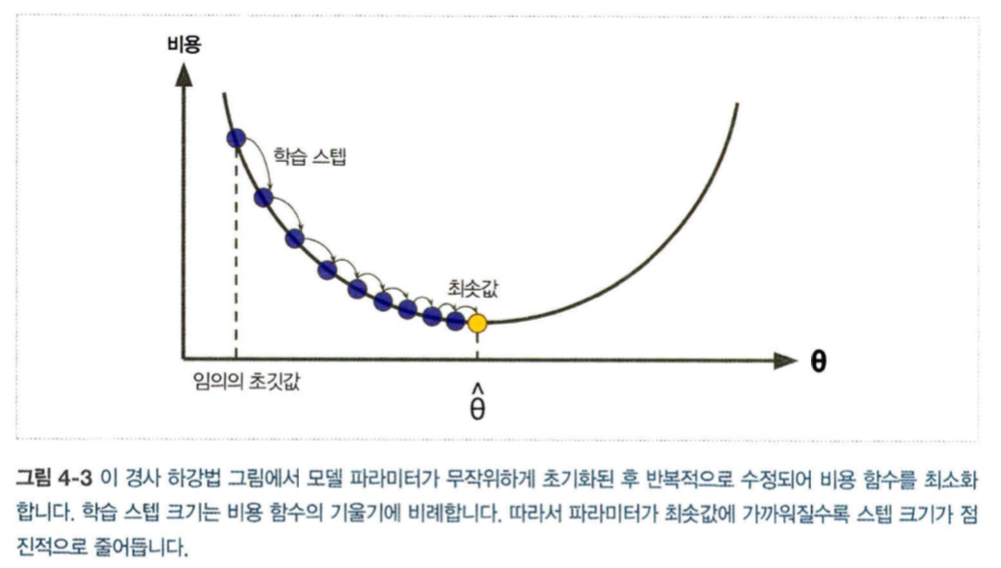

경사 하강법에서 중요한 파라미터는 스텝의 크기로, learning_rate 하이퍼파라미터로 결정됨. 너무 작으면 수렴을 위해 많은 반복이 필요하고, 너무 작으면 이전보다 더 높은 gradient로 갈지도 모르므로 적절한 조정이 필요함.

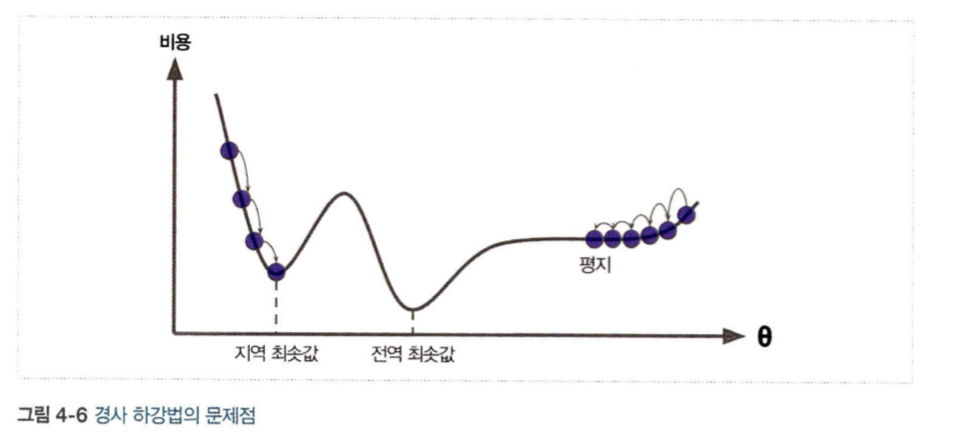

또한, 위의 그래프처럼 무작위 초기화로 theta가 시작될 경우, 시작점에 따라 global minimum이 아닌 local minimum에 수렴할 수도 있음. 또, 오른쪽에서 시작할 경우 평지를 지나기 위해 많은 시간이 소요되며 성능 향상이 미미할 경우 global minimum에 도달하지 못하고 멈추게 될 수 있음.

선형 회귀를 위한 mse 비용 함수는 볼록 함수라 local이 없고 global만 존재. 또한 연속된 함수이며, 기울기가 갑자기 변하지 않음. 따라서 적절한 학습률과 충분한 시간이 있다면 global minimum에 가깝게 접근 가능함.

경사 하강법 구현을 위해서는 각 모델 파라미터 theta에 대해 비용 함수의 gradient를 계산해야 함. 이를 partial derivative(편도 함수)라 함.

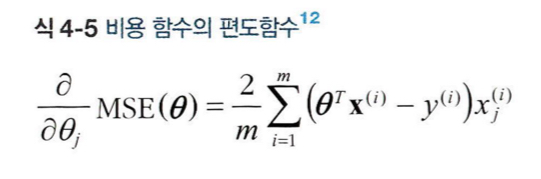

# 4.2.1 배치 경사 하강법

편도함수를 각각 계산하는 대신 다음과 같은 방법으로 한꺼번에 계산 가능

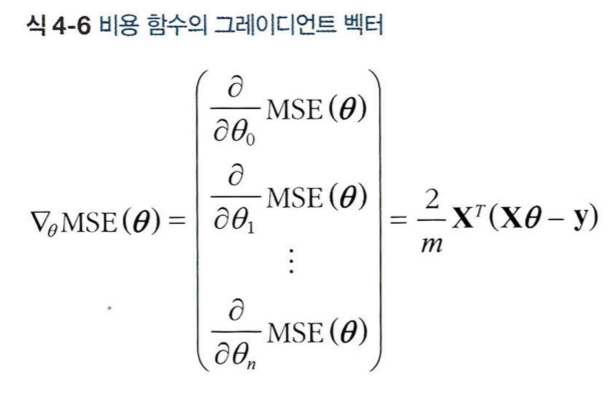

매 경사 하강법 스텝에서 전체 훈련 세트 X에 대해 계산하는 공식으로, 이 알고리즘을 배치 경사 하강법이라 함. 매 스텝에서 훈련 데이터 전체를 사용함. 매우 큰 훈련 세트에서는 느림.

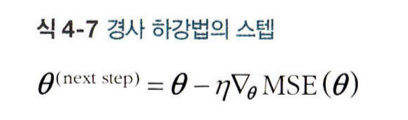

In [19]:
eta = 0.1 # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # 무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

theta

array([[4.04109299],
       [2.91405433]])

# 4.2.2 확률적 경사 하강법

전체 훈련 세트를 사용하는 배치 경사 하강법과 달리 매 스텝에서 한 개의 샘플을 무작위로 선택하고 하나의 샘플에 대한 gradient 계산. 속도가 매우 빠르나 비용 함수가 최솟값에 다다를 때까지 요동치면서 움직이기 때문에 불안정함. 불규칙한 비용 함수에서는 배치 경사 하강법보다 전역 최솟값을 찾을 가능성 높음. 그러나 무작위성 때문에 전역 최솟값에 다다르지 못하는 경우 많음.

이를 해결하는 방법으로, 학습률을 점진적으로 감소시키는 방법이 존재
> 시작할 때는 학습률을 크게 하여 수렴을 빠르게 하고, 지역 최솟값에 빠지지 않도록 함. 그리고 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달하도록 함.

매 반복에서 학습률을 결정하는 함수: 학습 스케줄(learning schedule)

In [ ]:
# 학습 스케줄 사용한 확률적 경사 하강법의 구현

In [20]:
n_epochs = 50
t0, t1 = 5, 50 # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2, 1) # 무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

theta

array([[4.01866032],
       [2.95631349]])

샘플을 무작위로 선택하는 방식이기 때문에 어떤 샘플은 한 에포크에서 여러 번 선택될 수 있고, 어떤 샘플은 전혀 선택되지 못할 수 있음. 에포크마다 모든 샘플을 사용하게 하려면 훈련 세트를 섞은 후 차례대로 하나씩 선택하고 다음 에포크에서 다시 섞는 식의 방법을 사용할 수 있음.

사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스를 사용.

In [23]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [24]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.95949611]), array([2.85233033]))

# 4.2.3 미니배치 경사 하강법

미니배치라 부르는 임의의 작은 샘플 세트에 대해 gradient 계산. 확률적 경사 하강법보다 덜 불규칙적으로 움직이지만, 그만큼 지역 최솟값에서 더 빠져나오기 힘들 확률이 높음.

# 배치, 확률적, 미니배치 비교

배치는 최솟값에서 멈춘 반면, 확률적과 미니배치는 근처에서 맴돌고 있음. 그러나 배치는 시간이 매 스텝마다 많이 소요되므로, 확률적과 미니배치에서 적절한 학습 스케줄을 사용하는 방법이 더 효율적일 때가 있음

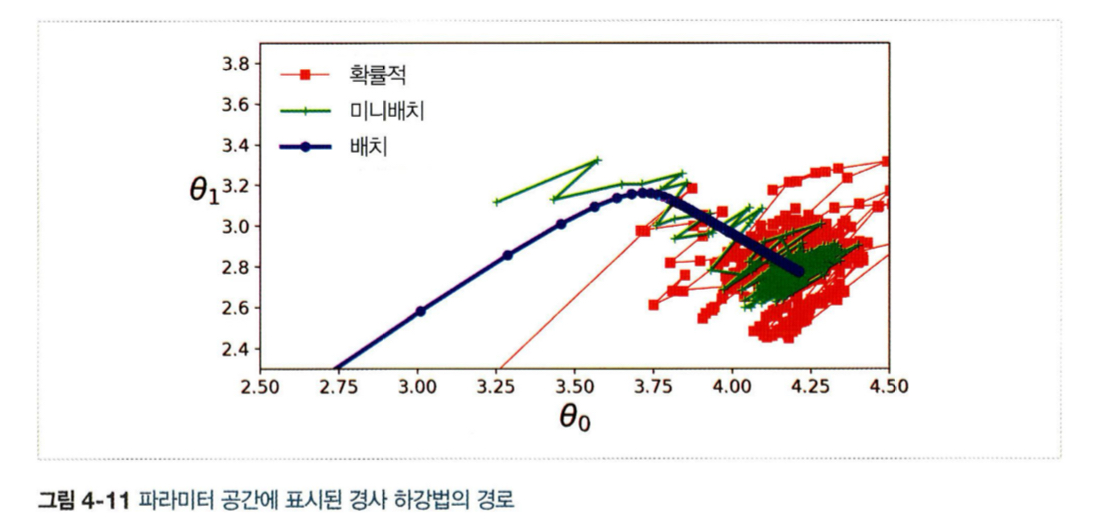

지금까지 논의한 알고리즘을 선형 회귀를 사용해 비교

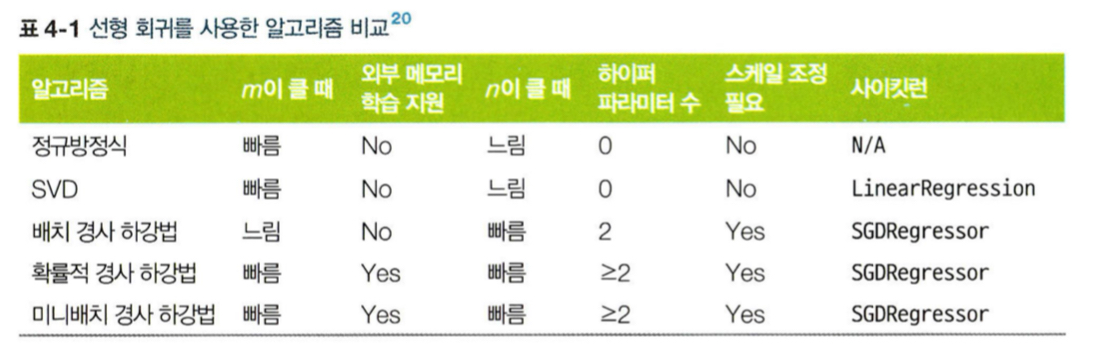

# 4.3 다항 회귀

비선형 데이터를 학습할 때 각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련시키는 방법으로 선형 모델 사용 가능 -> 다항 회귀

다항 회귀는 특성이 여러 개일 때 특성 사이의 관계를 찾을 수 있음.  

a, b 특성이 있고 degree = 3일 때 ab, ab^2 등도 특성으로 추가함

In [25]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

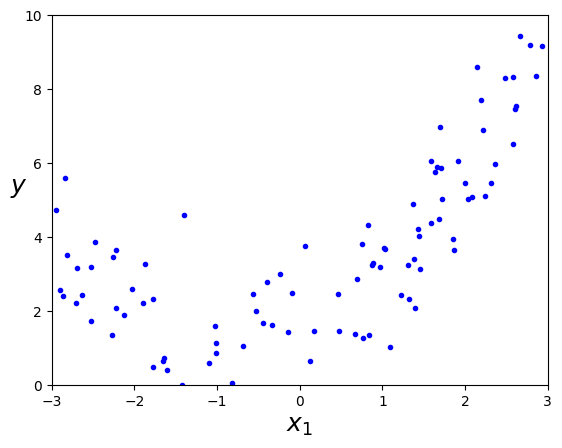

In [26]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.23466187])

In [29]:
X_poly[0]

array([-0.23466187,  0.05506619])

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.53607624]), array([[0.95820785, 0.57372769]]))

# 4.4 학습 곡선

고차 다항 회귀 모델은 훈련 데이터에 과대적합되며, 선형 모델은 과소적합될 수 있음. 모델의 복잡성을 결정 짓는 방법으로는 교차 검증과 학습 곡선 살펴보기가 있음

학습 곡선: 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타냄. 그래프 생성을 위해서는 단순히 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러 번 훈련시키면 됨.

In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")

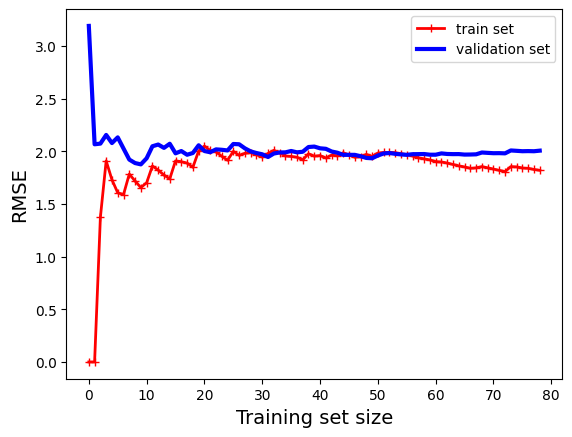

In [32]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.xlabel("Training set size", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.legend()
plt.show()

과소적합된 것을 알 수 있음

훈련 세트에 샘플이 추가됨에 따라 잡음도 있고 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습하는 것이 불가능해짐. 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해 있음.

-> 과소적합됐을 경우에는 더 복잡한 모델을 사용하거나 더 나은 특성 선택해야 함. 훈련 샘플을 더 추가하는 건 효과 없음.

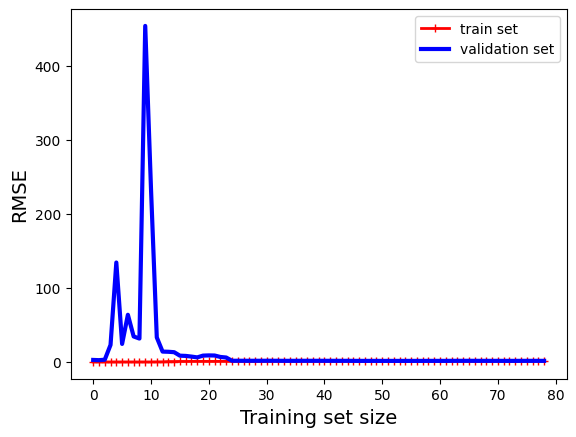

In [33]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.xlabel("Training set size", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.legend()
plt.show()

훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮고, 두 곡선 사이에 공간 존재. 즉, 훈련 데이터에 과대적합 되었다는 것.